In [1]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import scipy.stats as stats
from scipy import interp
from itertools import cycle

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from utils.smart_utils import FuturoCube, calc_cos_sim, get_other_label
from preprocessing.process_data import get_data

from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc
from skfeature.function.similarity_based import reliefF

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.manifold import TSNE
from collections import OrderedDict

%matplotlib inline
%load_ext autoreload
%autoreload 2

PLOT_OUTPUT_DIR = '/home/jogi/git/repository/smart_play_set/plots/'

In [2]:
"""
    (1) Two-Sample T-Test: stats.ttest_ind
    (2) Paired T-Test (difference within the same group at different times)
                    stats.ttest_rel(a = before, b = after)
"""
def compute_t_test(X, y, feature_idxs, features, class_labels=[0,1]):
    
    # assuming binary classes
    normal = y == class_labels[0]
    positive = y == class_labels[1]
    print("Normal/Positive ", np.count_nonzero(normal), np.count_nonzero(positive))
    
    for f in feature_idxs:
        n_group = X[normal, f]
        p_group = X[positive, f]

        t_value, p_value = stats.ttest_ind(a=n_group, b=p_group, equal_var=False)    
        print("Feature %s: t_value %.4f, p_value %.4f, mean-normal %.3f, mean-positive %.3f" % 
             (features[f], t_value, p_value, np.mean(n_group), np.mean(p_group)))
        

# y_labels = y_labels_2c[:]
# compute_t_test(x_train_all, y_labels, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], features)

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def create_level_sets(X, skill_labels, level_labels):
    
    unique_levels = np.unique(level_labels)
    print("INFO -- create_level_sets ", unique_levels)
    datasets = {}
    for l in unique_levels:
        rows = np.where(level_labels==l)[0]
        x_data = X[rows]
        y_data = skill_labels[rows]
        datasets[l] = (x_data, y_data)
    
    return datasets
    
def get_features(mask, features):

    for i, f in enumerate(mask):
        print("%d. %s" % (i+1, features[f]))

        
def transform_x(X, features_idx):
    
    X_new = np.zeros((X.shape[0], len(features_idx)))
    for i, idx in enumerate(features_idx):
        X_new[:, i] = X[:, idx]
        
    return X_new


def prepare_data(option=330, two_class_opt='2_and_1'):
    
    if option == 330:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_330_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 180:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_180_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)

    elif option == 990:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_990_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 3960:  # 5 seconds with 0.5 overlapping
        
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_3960_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    else:
        raise NotImplementedError("Error, %s as option is not implemented" % str(option))

    features = dta_dict_f['features']

    y_labels_all = np.squeeze(y_labels_all)
    y_labels_2c = np.zeros(y_labels_all.shape[0], dtype=np.int)
    y_labels_2c[:] = y_labels_all[:]
    if two_class_opt == 'merge_1_2':
        # merge group 1 and 2
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'merge_0_1':
        # merge 1 with 0 group
        y_labels_2c[y_labels_2c==1] = 0
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'only_0_2':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all[y_labels_all==2] = 1
        y_labels_2c = y_labels_all
    elif two_class_opt == 'only_0_1':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_2c = y_labels_all
        
    print("Unique labels y_labels_all ", np.unique(y_labels_all))
    print("Unique labels y_labels_2c ", np.unique(y_labels_2c))
    print("Class counts y_labels_all ", np.bincount(y_labels_all))
    print("Class counts y_labels_2c ", np.bincount(y_labels_2c))
    print("Shape x_train_all ", x_train_all.shape)
    print("Shape y_labels_all ", y_labels_all.shape)
    
    return x_train_all, y_labels_all, y_labels_2c, y_other_labels, features

x_train_all, y_labels_all, y_labels_2c, y_other_labels, features = prepare_data(330, two_class_opt='merge_1_2')
level_datasets = create_level_sets(x_train_all, y_labels_2c, get_other_label(y_other_labels, 'level'))
for key, data in level_datasets.iteritems():
    print(key, data[0].shape, data[1].shape)
y_label_id = get_other_label(y_other_labels, "ID")
y_label_perm = get_other_label(y_other_labels, "perm")
y_label_level = get_other_label(y_other_labels, "level")
print(features)

INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.
(210,)
(120,)
Unique labels y_labels_all  [0 1 2]
Unique labels y_labels_2c  [0 1]
Class counts y_labels_all  [210  60  60]
Class counts y_labels_2c  [210 120]
Shape x_train_all  (330, 12)
Shape y_labels_all  (330,)
INFO -- create_level_sets  [1 2 3]
1 (110, 12) (110,)
2 (110, 12) (110,)
3 (110, 12) (110,)
[u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']


======= 12 feature-ranking =======
gnb(12) - Accuracy: 0.636 (+/- 0.241)
gnb(12) - f1: 0.609 (+/- 0.240)
gnb(12) - recall: 0.636 (+/- 0.241)
svc(12) - Accuracy: 0.664 (+/- 0.120)
svc(12) - f1: 0.585 (+/- 0.162)
svc(12) - recall: 0.664 (+/- 0.120)
Ranked features  [u'range', u'mean_squared_jerk', u'minf', u'std', u'power_spec_entropy', u'rms', u'cos_sim', u'median', u'energy', u'mean', u'dc', u'maxf']
Ranked features idx  [11, 2, 0, 9, 5, 1, 6, 10, 4, 8, 3, 7]
Normal/Positive  210 60
Feature range: t_value -1.7815, p_value 0.0783, mean-normal -0.070, mean-positive 0.195
Feature mean_squared_jerk: t_value -6.7036, p_value 0.0000, mean-normal -0.318, mean-positive 0.495
Feature minf: t_value 1.6808, p_value 0.0953, mean-normal 0.082, mean-positive -0.125
Feature std: t_value 0.1941, p_value 0.8464, mean-normal -0.054, mean-positive -0.079
Feature power_spec_entropy: t_value -2.9475, p_value 0.0041, mean-normal -0.170, mean-positive 0.251
Feature rms: t_value -1.5036, p_value 0.1359, mean-

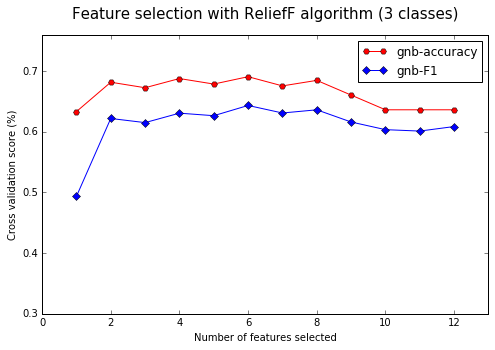

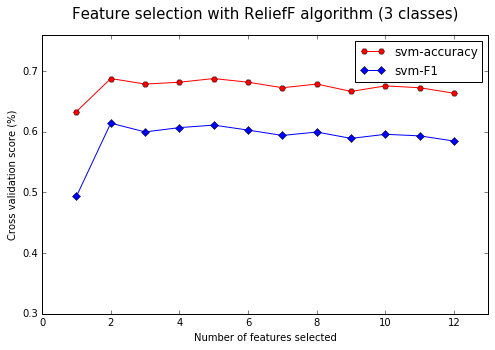

In [7]:
# y_labels = y_labels_2c[:]
y_labels = y_labels_all
# best with 3 classes, 6 features [u'mean_squared_jerk', u'range', u'mean', u'std', u'minf', u'rms']
"""
best with 2 classes:
====================
(1) 8 features
gnb(8) - Accuracy: 0.742 (+/- 0.265)
gnb(8) - f1: 0.602 (+/- 0.412)
svc(8) - Accuracy: 0.718 (+/- 0.197)
svc(8) - f1: 0.471 (+/- 0.401)

mean_squared_jerk 44.2379689568
std 22.2526246915
median 18.7887949492
cos_sim 17.3191976537
mean 15.3754210695
energy 14.7320186932
rms 14.470910009
minf 12.3461975466

or 
(2) 6 features
gnb(6) - Accuracy: 0.745 (+/- 0.243)
gnb(6) - f1: 0.595 (+/- 0.402)
svc(6) - Accuracy: 0.715 (+/- 0.201)
svc(6) - f1: 0.469 (+/- 0.394)

mean_squared_jerk 45.208456643
std 28.1811006354
mean 16.9884122425
median 14.3950405564
cos_sim 12.7935735104
rms 10.8215152881
"""

kept_feature_dict = {}
res_gnb_acc = []
res_gnb_f1 = []
res_gnb_rc = []
res_svc_acc = []
res_svc_f1 = []
res_svc_rc = []

feature_list = [f for f in features]
train_data = np.zeros_like(x_train_all)
train_data[:] = x_train_all[:]
# train_data = level_datasets[1][0]
# y_labels = level_datasets[1][1]

gnb = GaussianNB()
svc = SVC(kernel="rbf", C=1.)
linearSVC = LinearSVC(C=1., penalty="l2", dual=False, loss='squared_hinge')
num_of_times = 25
k = 10
num_of_classes = len(np.unique(y_labels))
num_of_samples = train_data.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])
feature_list_length = []
    
for f_num in np.arange(len(features)):
    print("======= %d feature-ranking =======" % len(feature_list))
    feature_list_length.append(len(feature_list))
    scores_acc_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
    scores_acc_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
    
    scores_f1_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
    scores_rc_gnb = cross_val_score(gnb, train_data, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
    scores_f1_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
    scores_rc_svc = cross_val_score(svc, train_data, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
    
    
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_acc_gnb.mean(), 
                                                     scores_acc_gnb.std() * 2))

    print("gnb(%d) - f1: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_f1_gnb.mean(), 
                                               scores_f1_gnb.std() * 2))
    print("gnb(%d) - recall: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_rc_gnb.mean(), 
                                               scores_rc_gnb.std() * 2))
    res_gnb_f1.append(scores_f1_gnb.mean())
    res_gnb_rc.append(scores_rc_gnb.mean())
        
    res_gnb_acc.append(scores_acc_gnb.mean())
        
    print("svc(%d) - Accuracy: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_acc_svc.mean(), 
                                                     scores_acc_svc.std() * 2))

    print("svc(%d) - f1: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_f1_svc.mean(), 
                                               scores_f1_svc.std() * 2))
    print("svc(%d) - recall: %0.3f (+/- %0.3f)" % (train_data.shape[1], scores_rc_svc.mean(), 
                                               scores_rc_svc.std() * 2))
    res_svc_f1.append(scores_f1_svc.mean())
    res_svc_rc.append(scores_rc_svc.mean())
        
    res_svc_acc.append(scores_acc_svc.mean())
    final_score = np.zeros(len(feature_list))

    for i in np.arange(num_of_times):
        new_relief_score = reliefF.reliefF(train_data, y_labels, **{"k": k})
        final_score += new_relief_score

    final_score /= num_of_times
    
    new_feature_list = []
    new_feature_idx = []
    for i, idx in enumerate(np.argsort(final_score)[::-1]):
        # print(feature_list[idx], final_score[idx])
        new_feature_list.append(feature_list[idx])
        new_feature_idx.append(idx)
    
    print("Ranked features ", new_feature_list)
    print("Ranked features idx ", new_feature_idx)
    kept_feature_dict[len(new_feature_list)] = new_feature_list
    compute_t_test(train_data, y_labels, new_feature_idx, feature_list)
    
    feature_list = new_feature_list[:-1]
    new_feature_idx = new_feature_idx[:-1]
    train_data = transform_x(train_data, new_feature_idx)
    print("New shape train_data ", train_data.shape)
    
    
# Plot number of features VS. cross-validation scores
markers = ['D', 'H'] # x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
colors = ['b', 'r', 'y']
plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_gnb_acc, 'Hr-', label="gnb-accuracy")

plt.plot(feature_list_length, res_gnb_f1, 'Db-', label="gnb-F1")
# plt.plot(feature_list_length, res_gnb_rc, 'xg-', label="gnb-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'gnb_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_svc_acc, 'Hr-', label="svm-accuracy")

plt.plot(feature_list_length, res_svc_f1, 'Db-', label="svm-F1")
# plt.plot(feature_list_length, res_svc_rc, 'xg-', label="svm-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'svm_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

Save to /home/jogi/git/repository/smart_play_set/plots/gnb_feature_sel_reliefF_330_2_01classes.png
Save to /home/jogi/git/repository/smart_play_set/plots/svm_feature_sel_reliefF_330_2_01classes.png


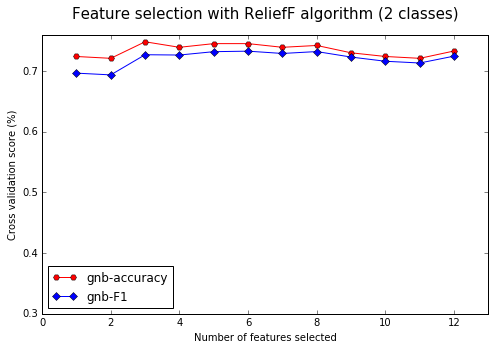

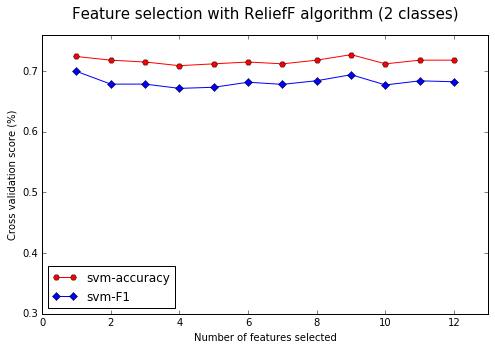

In [29]:
# Plot number of features VS. cross-validation scores
markers = ['D', 'H'] # x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
colors = ['b', 'r', 'y']
plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_gnb_acc, 'Hr-', label="gnb-accuracy")
plt.plot(feature_list_length, res_gnb_f1, 'Db-', label="gnb-F1")
# plt.plot(feature_list_length, res_gnb_rc, 'xg-', label="gnb-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'gnb_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

plt.figure(figsize=(8, 5))
plt.xlim([0, len(features)+1])
plt.ylim([0.30,0.76])
plt.title("Feature selection with ReliefF algorithm (%d classes)" % len(np.unique(y_labels)), fontsize=15, y=1.04)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (%)")
plt.plot(feature_list_length, res_svc_acc, 'Hr-', label="svm-accuracy")

plt.plot(feature_list_length, res_svc_f1, 'Db-', label="svm-F1")
# plt.plot(feature_list_length, res_svc_rc, 'xg-', label="svm-recall")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'svm_feature_sel_reliefF_' + str(num_of_samples) + "_" + str(num_of_classes) + \
                                "_" + class_labels + 'classes.png'

print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

[0 1]
--- Most predictive features SVM ---
1. minf
2. rms
3. mean_squared_jerk
4. dc
5. energy
6. power_spec_entropy
7. maxf
8. mean
9. std
10. median

--- Most predictive features RandomForest ---
1. mean_squared_jerk
2. cos_sim
3. median
Save to /home/jogi/git/repository/smart_play_set/plots/feature_sel_RFE_330_2_01classes.png
--- Final score with k-fold cross-validation
x_train_svc.shape  (330, 10)
x_train_rfc.shape  (330, 3)
svc - Accuracy: 0.73 (+/- 0.27)
svc - F1: 0.53 (+/- 0.47)
rfc - Accuracy: 0.72 (+/- 0.21)
rfc - F1: 0.51 (+/- 0.39)
gnb(10)- Accuracy: 0.72 (+/- 0.31)
gnb(10) - F1: 0.56 (+/- 0.48)
gnb(3) - Accuracy: 0.74 (+/- 0.24)
gnb(3) - F1: 0.57 (+/- 0.37)


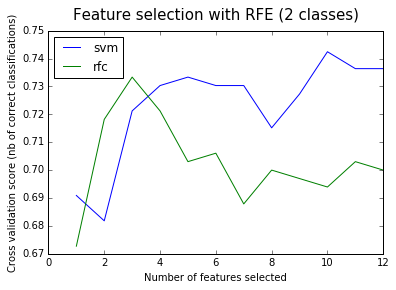

In [39]:
# y_labels = y_labels_all
y_labels = y_labels_2c[:]

print(np.unique(y_labels))

"""
    It operates by trying to choose the σ_0 features which lead to the largest margin of
    class separation, using an SVM classifier. This combinatorial
    problem is solved in a greedy fashion at each iteration of training by removing
    the input dimension that decreases the margin the least until only σ_0 input
    dimensions remain.
"""

# Create the RFE object and compute a cross-validated score.

linearSVC = LinearSVC(C=1., penalty="l2", dual=False, loss='squared_hinge')
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_res = np.zeros(x_train_all.shape[1])
opt_feature_num = []

for i in np.arange(1):
    rfecv_svc = RFECV(estimator=OneVsRestClassifier(linearSVC), step=1, cv=StratifiedKFold(10),
                  scoring='accuracy')
    x_train_svc = rfecv_svc.fit_transform(x_train_all, y_labels)
    print("--- Most predictive features SVM ---")
    get_features(np.where(np.array(rfecv_svc.ranking_)==1)[0], features)
    opt_feature_num.append(rfecv_svc.n_features_)
    
    print("")
    rfecv_rfc = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10),
                          scoring='accuracy')  # scoring='roc_auc', 'accuracy', 'f1'
    x_train_rfc = rfecv_rfc.fit_transform(x_train_all, y_labels)
    print("--- Most predictive features RandomForest ---")
    get_features(np.where(np.array(rfecv_rfc.ranking_)==1)[0], features)
    
    opt_feature_num.append(rfecv_rfc.n_features_)
    
# Plot number of features VS. cross-validation scores
num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
class_labels = "".join([str(int(i)) for i in np.unique(y_labels)])

plt.figure()
plt.title("Feature selection with RFE (%d classes)" % num_of_classes, fontsize=15, y=1.03)

plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_svc.grid_scores_) + 1), rfecv_svc.grid_scores_, label="svm")
plt.plot(range(1, len(rfecv_rfc.grid_scores_) + 1), rfecv_rfc.grid_scores_, label="rfc")
plt.legend(loc="best")
outfile = PLOT_OUTPUT_DIR + 'feature_sel_RFE_' + str(num_of_samples) + "_" + str(num_of_classes) + "_" + \
                             class_labels + 'classes.png'
print("Save to %s" % outfile)
plt.savefig(outfile, dpi=100)

print("--- Final score with k-fold cross-validation")
print("x_train_svc.shape ", x_train_svc.shape)
print("x_train_rfc.shape ", x_train_rfc.shape)
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), x_train_rfc, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
print("svc - Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), x_train_rfc, y_labels, cv=StratifiedKFold(10),
                             scoring='f1')
print("svc - F1: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))


scores_rfc = cross_val_score(rfc, x_train_svc, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("rfc - Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))
scores_rfc = cross_val_score(rfc, x_train_svc, y_labels, cv=StratifiedKFold(10), scoring='f1')
print("rfc - F1: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))

scores_gnb = cross_val_score(gnb, x_train_svc, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d)- Accuracy: %0.2f (+/- %0.2f)" % (x_train_svc.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, x_train_svc, y_labels, cv=StratifiedKFold(10), scoring='f1')
print("gnb(%d) - F1: %0.2f (+/- %0.2f)" % (x_train_svc.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

scores_gnb = cross_val_score(gnb, x_train_rfc, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.2f (+/- %0.2f)" % (x_train_rfc.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
                                              
scores_gnb = cross_val_score(gnb, x_train_rfc, y_labels, cv=StratifiedKFold(10), scoring='f1')
print("gnb(%d) - F1: %0.2f (+/- %0.2f)" % (x_train_rfc.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

In [97]:
rfe_scores_svc = rfecv_svc.estimator_.coef_[0]
print(rfe_scores_svc)
print(len(rfe_scores_svc))

for idx in np.argsort(rfe_scores_svc)[::-1]:
    print(features[idx], rfe_scores_svc[idx])
    
mean_squared_jerk 34.8972741798
std 24.0441177895
range 22.6542765053
minf 20.1410966313
median 15.1042116597
cos_sim 14.2017082944
rms 10.7781425512
mean 10.5083980689
energy 10.1666460502
power_spec_entropy 8.68788676078
maxf 1.23540936162
dc 1.23540936162

[-0.08483969  0.1150275   0.47191027 -0.12791063 -0.26671998 -0.2025693
 -0.12791063  0.28673337  0.13155702  0.11809924]
10
mean_squared_jerk 0.471910266492
maxf 0.286733366819
mean 0.131557022159
std 0.118099244965
rms 0.115027495544
minf -0.0848396873421
dc -0.127910632237
cos_sim -0.127910632237
power_spec_entropy -0.202569302693
energy -0.2667199822


In [55]:
#     0       1             2              3         4              5
# [u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', 
#                                                      6          7       8        9        10         11
#                                                  u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']
"""
mean_squared_jerk 45.208456643
std 28.1811006354
mean 16.9884122425
median 14.3950405564
cos_sim 12.7935735104
rms 10.8215152881
"""
svm = SVC(kernel="rbf", C=1.)
feature_list = [2,5,6]   # scores well on GNB
# feature_list = [2, 6]
# feature_list = [ 2, 9, 8, 10, 6, 1]   # feature list from ReliefF algo with 2 classes
new_X = transform_x(x_train_all, feature_list)
compute_t_test(x_train_all, y_labels, feature_list, features)

print("--- Final score with k-fold cross-validation")
print("x_train_svc.shape ", x_train_svc.shape)
print("x_train_rfc.shape ", x_train_rfc.shape)
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
print("linear svc - Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))

scores_svm = cross_val_score(OneVsRestClassifier(svm), new_X, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
print("SVM-rbf(%d)) - Accuracy: %0.2f (+/- %0.2f)" % (new_X.shape[1], scores_svm.mean(), scores_svm.std() * 2))

scores_rfc = cross_val_score(rfc, new_X, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("rfc(%d) - Accuracy: %0.2f (+/- %0.2f)" % (new_X.shape[1], scores_rfc.mean(), scores_rfc.std() * 2))


scores_svc = cross_val_score(gnb, new_X, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d)- Accuracy: %0.2f (+/- %0.2f)" % (new_X.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_rfc = cross_val_score(gnb, new_X, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.2f (+/- %0.2f)" % (new_X.shape[1], scores_rfc.mean(), scores_rfc.std() * 2))

scores_gnb = cross_val_score(gnb, x_train_all, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.2f (+/- %0.2f)" % (x_train_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

                                               
scores_gnb = cross_val_score(gnb, new_X, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.2f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

Normal/Positive  210 120
Feature mean_squared_jerk: t_value -7.2534, p_value 0.0000, mean-normal -0.318, mean-positive 0.556
Feature power_spec_entropy: t_value -4.0204, p_value 0.0001, mean-normal -0.170, mean-positive 0.297
Feature cos_sim: t_value -5.4546, p_value 0.0000, mean-normal -0.223, mean-positive 0.390
--- Final score with k-fold cross-validation
x_train_svc.shape  (330, 10)
x_train_rfc.shape  (330, 3)
linear svc - Accuracy: 0.74 (+/- 0.31)
SVM-rbf(3)) - Accuracy: 0.75 (+/- 0.18)
rfc(3) - Accuracy: 0.73 (+/- 0.26)
gnb(3)- Accuracy: 0.75 (+/- 0.25)
gnb(3) - Accuracy: 0.75 (+/- 0.25)
gnb(12) - Accuracy: 0.73 (+/- 0.27)
gnb(3) - Accuracy: 0.75 (+/- 0.25)


Normal/Positive  210 120
Feature mean_squared_jerk: t_value -7.2534, p_value 0.0000, mean-normal -0.318, mean-positive 0.556
Feature power_spec_entropy: t_value -4.0204, p_value 0.0001, mean-normal -0.170, mean-positive 0.297
Feature cos_sim: t_value -5.4546, p_value 0.0000, mean-normal -0.223, mean-positive 0.390
--- Final score with k-fold cross-validation
svc(3) - Accuracy: 0.736 (+/- 0.31)
svc(3) - F1: 0.714 (+/- 0.34)
svc(3) - Precision: 0.735 (+/- 0.36)
svc(3) - Recall: 0.736 (+/- 0.31)
gnb(3) - Accuracy: 0.745 (+/- 0.25)
gnb(3) - F1: 0.726 (+/- 0.27)
gnb(3) - Precision: 0.744 (+/- 0.29)
gnb(3) - Recall: 0.745 (+/- 0.25)
Confusion matrix, without normalization
[[188  22]
 [ 65  55]]


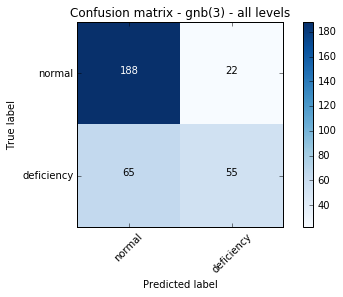

--- Evaluation of classifier per level-dataset
shape of new_x (110, 3) (110,)
Evaluation for level (1)
gnb(3) - Accuracy: 0.718 (+/- 0.29)
gnb(3) - F1: 0.674 (+/- 0.36)
gnb(3) - Precision: 0.678 (+/- 0.44)
gnb(3) - Recall: 0.718 (+/- 0.29)
Confusion matrix, without normalization
[[64  6]
 [24 16]]


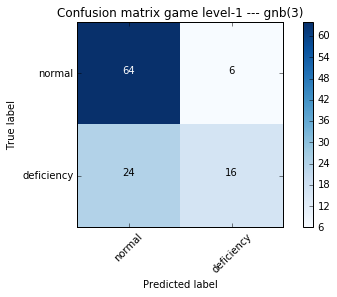

shape of new_x (110, 3) (110,)
Evaluation for level (2)
gnb(3) - Accuracy: 0.782 (+/- 0.19)
gnb(3) - F1: 0.764 (+/- 0.20)
gnb(3) - Precision: 0.793 (+/- 0.23)
gnb(3) - Recall: 0.782 (+/- 0.19)
Confusion matrix, without normalization
[[67  3]
 [18 22]]


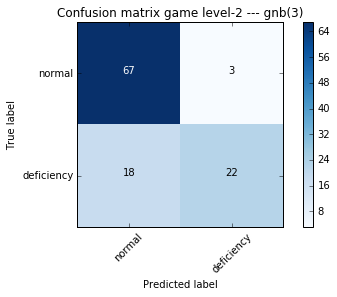

shape of new_x (110, 3) (110,)
Evaluation for level (3)
gnb(3) - Accuracy: 0.736 (+/- 0.42)
gnb(3) - F1: 0.731 (+/- 0.42)
gnb(3) - Precision: 0.746 (+/- 0.43)
gnb(3) - Recall: 0.736 (+/- 0.42)
Confusion matrix, without normalization
[[61  9]
 [16 24]]


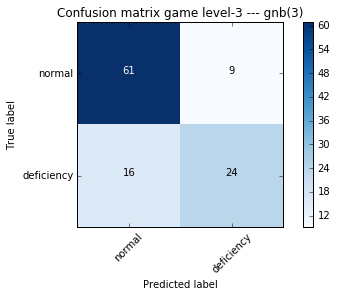

In [9]:
#     0       1             2              3         4              5
# [u'minf', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', 
#                                                      6          7       8        9        10         11
#                                                  u'cos_sim', u'maxf', u'mean', u'std', u'median', u'range']

y_labels = y_labels_2c[:]
# y_labels = y_labels_all

feature_list = [2,5,6]
# feature_list = [2, 9, 10, 6, 8, 1, 4, 0]   # feature list from ReliefF algo with 2 classes
# [u'mean_squared_jerk', u'std', u'median', u'cos_sim', u'mean', u'rms', u'energy', u'minf']
new_X_all = transform_x(x_train_all, feature_list)

compute_t_test(x_train_all, y_labels, feature_list, features)

print("--- Final score with k-fold cross-validation")

scores_svc_acc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10),
                             scoring='accuracy')
scores_svc_f1 = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10),
                             scoring='f1_weighted')
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='accuracy')
print("svc(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='f1_weighted')
print("svc(%d) - F1: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='precision_weighted')
print("svc(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), new_X_all, y_labels, cv=StratifiedKFold(10), 
                             scoring='recall_weighted')
print("svc(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_svc.mean(), scores_svc.std() * 2))



scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='accuracy')
print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='f1_weighted')
print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='precision_weighted')
print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
scores_gnb = cross_val_score(gnb, new_X_all, y_labels, cv=StratifiedKFold(10), scoring='recall_weighted')
print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X_all.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))

c_matrix = confusion_matrix(y_labels, y_pred)
plt.figure()
plot_title = "Confusion matrix - gnb(%d) - all levels" % new_X_all.shape[1]
plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title=plot_title)
plt.show()

print("===================================================================")
print("--- Evaluation of classifier per level-dataset")
for key, data in level_datasets.iteritems():
    x_data = data[0]
    y_data = data[1]
    new_X = transform_x(x_data, feature_list)
    print("shape of new_x", new_X.shape, y_data.shape)
    print("Evaluation for level (%d)" % key)
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='accuracy')
    print("gnb(%d) - Accuracy: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='f1_weighted')
    print("gnb(%d) - F1: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='precision_weighted')
    print("gnb(%d) - Precision: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    scores_gnb = cross_val_score(gnb, new_X, y_data, cv=StratifiedKFold(10), scoring='recall_weighted')
    print("gnb(%d) - Recall: %0.3f (+/- %0.2f)" % (new_X.shape[1], scores_gnb.mean(), scores_gnb.std() * 2))
    
    gnb.fit(new_X, y_data)
    y_pred = gnb.predict(new_X)
    c_matrix = confusion_matrix(y_data, y_pred)
    plt.figure()
    plot_title = "Confusion matrix game level-%d --- gnb(%d)" % (key, new_X.shape[1])
    plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title=plot_title)
    plt.show()
    

gnb.fit(new_X_all, y_labels)
y_pred = gnb.predict(new_X_all)



--- Final score with k-fold cross-validation
svc - Accuracy: 0.82 (+/- 0.00)
gnb - Accuracy: 0.82 (+/- 0.05)
Save to /home/jogi/git/repository/smart_play_set/plots/30sec_2f_990_2classes-tsne_projection.png


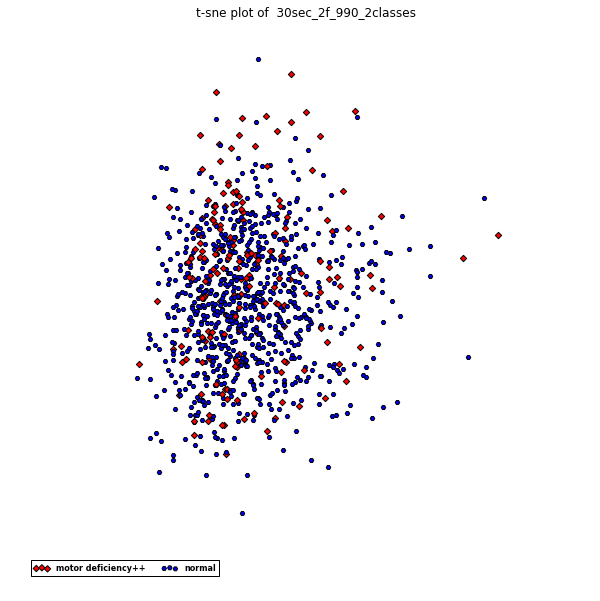

In [11]:
def visualize_2d(x_data, labels, logpath, prefix=None, width=10, height=10):
    
    labels = labels.astype(float)
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', '#ff6666', '#66ff66', '#6666ff', '#666666']
    colors = ['b', 'y', 'r']
    # markers = ['x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
    markers = ['H', '8', 'D']
    legend_labels = ['normal', 'motor deficiency+', 'motor deficiency++']
    
    plot_data = np.append(x_data, np.expand_dims(labels, axis=1), axis=1)
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)
    
    for x, y, c in plot_data.tolist():
        ax.scatter(x, y, c=colors[int(c)], marker=markers[int(c)], label=legend_labels[int(c)])

    # remove duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.axis('off')
    plt.title("t-sne plot of  " + prefix)
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', numpoints=1, ncol=5, fontsize=8)
    outfile = logpath + prefix + '-tsne_projection.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)
    

def visualize_features(features, labels, logpath='/home/jogi/git/repository/smart_play_set/plots/', prefix=None,
                       width=10, height=10):

    labels = labels.astype(float)
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', '#ff6666', '#66ff66', '#6666ff', '#666666']
    colors = ['b', 'y', 'r']
    # markers = ['x', '+', '^', 'D', '<', '>', '8', '*', 'H', 'o']
    markers = ['H', '8', 'D']
    legend_labels = ['normal', 'motor deficiency+', 'motor deficiency++']

    tsne = TSNE(n_components=2, random_state=0, learning_rate=1000)
    feature_projection = tsne.fit_transform(features)
    plot_data = np.append(feature_projection, np.expand_dims(labels, axis=1), axis=1)

    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)

    for x, y, c in plot_data.tolist():
        ax.scatter(x, y, c=colors[int(c)], marker=markers[int(c)], label=legend_labels[int(c)])

    # remove duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.axis('off')
    plt.title("2d plot of  " + prefix)
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', numpoints=1, ncol=5, fontsize=8)
    outfile = logpath + prefix + '-tsne_projection.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)
    
#   0      1     2    3     4       5     6        7              8    9          10                11 
# [minf, maxf, mean, std, median, range, rms, mean_squared_jerk, dc, energy, power_spec_entropy, cos_sim]
# ReliefF: cos_sim, power_spec_entropy, energy, dc, mean_squared_jerk

# x_train = transform_x(x_train_all, [11, 10, 9, 8, 7])
# x_train = transform_x(x_train_all, [7, 10])
x_train = transform_x(x_train_all, [11, 10])


print("--- Final score with k-fold cross-validation")
scores_svc = cross_val_score(OneVsRestClassifier(linearSVC), x_train, y_labels, cv=StratifiedKFold(10))
print("svc - Accuracy: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))
scores_gnb = cross_val_score(gnb, x_train, y_labels, cv=StratifiedKFold(30))
print("gnb - Accuracy: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))

# visualize_features(x_train, y_labels, PLOT_OUTPUT_DIR, prefix="30sec_2f_990_2classes")

visualize_2d(x_train, y_labels, PLOT_OUTPUT_DIR, prefix="30sec_2f_990_2classes")

RandomForest  :  [0, 1, 3, 5, 6, 7, 9, 10, 11]
Save to /home/jogi/git/repository/smart_play_set/plots/t_test_rfc_9f_330_2c_roc_curve.png


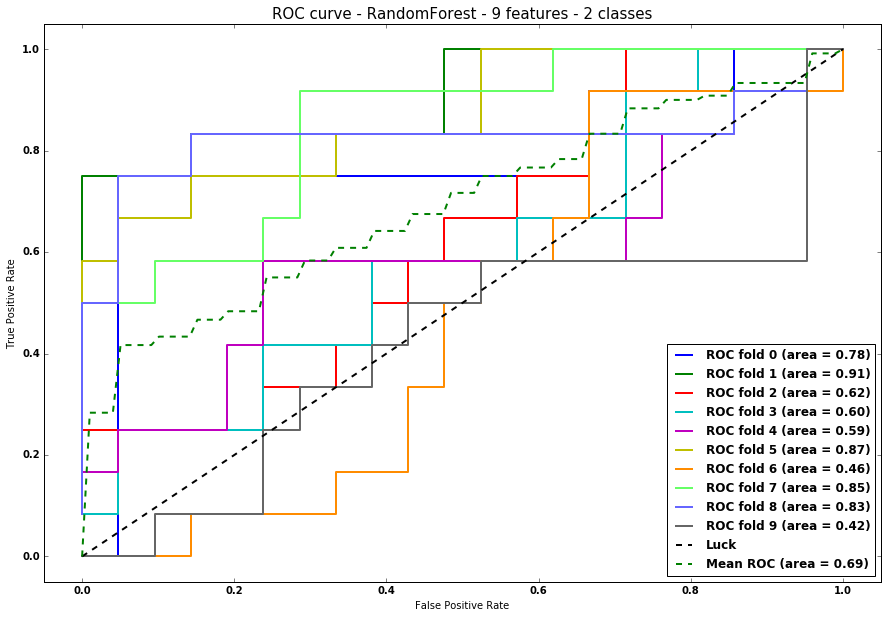

In [52]:

def plot_roc_auc(classifier, X, y_train, feature_idxs, p_title, logpath, prefix, k_fold=10):
    # Run classifier with cross-validation and plot ROC curves
    x_train = transform_x(X, feature_idxs)
    cv = StratifiedKFold(n_splits=k_fold)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'darkorange', '#66ff66', '#6666ff', '#666666'])
    lw = 2

    i = 0
    fig = plt.figure(figsize=(15, 10))

    for (train, test), color in zip(cv.split(x_train, y_labels), colors):
        probas_ = classifier.fit(x_train[train], y_labels[train]).predict_proba(x_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_labels[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(x_train, y_labels)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(p_title, fontsize=15)
    plt.legend(loc="lower right")
    outfile = logpath + prefix + '_roc_curve.png'
    print("Save to %s" % outfile)
    plt.savefig(outfile)

y_labels = y_labels_2c[:]
#   0      1     2    3     4       5     6        7              8    9          10                11 
# [minf, maxf, mean, std, median, range, rms, mean_squared_jerk, dc, energy, power_spec_entropy, cos_sim]
feature_set_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
one_feature = [11]
feature_set_svm1 = [7, 8, 9, 10, 11]
feature_set_svm2 = [7, 10]
# 1. minf 2. maxf 3. mean 4. std 5. range 6. mean_squared_jerk 7. energy 8. power_spec_entropy
feature_set_rfc = [0, 1, 2, 3, 5, 7, 9, 10]

feature_set_t_test = [0, 1, 3, 5, 6, 7, 9, 10, 11]

classifiers = {"rfc": "RandomForest", "gnb": "Naive Bayes", "svm": "SVM"}
clf_id = "rfc"
feature_set = feature_set_t_test

num_of_classes = len(np.unique(y_labels))
num_of_samples = x_train_all.shape[0]
prefix = "t_test_" + clf_id + "_" + str(len(feature_set)) + "f_" + str(num_of_samples) + "_2c" 

if clf_id == "rfc":
    print(classifiers[clf_id], " : ", feature_set)
    clf = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
elif clf_id == "gnb":
    print(classifiers[clf_id])
    clf = GaussianNB()
elif clf_id == "svm":
    print(classifiers[clf_id])
    clf = SVC(kernel="rbf", C=0.75, probability=True)
else:
    raise NotImplementedError("Unknown classifier")
    
p_title = "ROC curve - %s - %d features - 2 classes" % (classifiers[clf_id], len(feature_set))
plot_roc_auc(clf, x_train_all, y_labels, feature_set, p_title, PLOT_OUTPUT_DIR, prefix)

Normal/Positive  210 120
Feature minf: t_value 2.0555, p_value 0.0408, mean-normal 0.082, mean-positive -0.143
Feature maxf: t_value -4.6911, p_value 0.0000, mean-normal -0.198, mean-positive 0.347
Feature mean: t_value -1.6031, p_value 0.1103, mean-normal -0.068, mean-positive 0.119
Feature std: t_value -4.1096, p_value 0.0001, mean-normal -0.169, mean-positive 0.296
Feature median: t_value 0.0034, p_value 0.9973, mean-normal 0.000, mean-positive -0.000
Feature range: t_value -4.8673, p_value 0.0000, mean-normal -0.205, mean-positive 0.359
Feature rms: t_value -2.4713, p_value 0.0142, mean-normal -0.104, mean-positive 0.182
Feature mean_squared_jerk: t_value -7.2534, p_value 0.0000, mean-normal -0.318, mean-positive 0.556
Feature dc: t_value -1.1916, p_value 0.2346, mean-normal -0.050, mean-positive 0.087
Feature energy: t_value -1.9073, p_value 0.0576, mean-normal -0.077, mean-positive 0.136
Feature power_spec_entropy: t_value -4.0204, p_value 0.0001, mean-normal -0.170, mean-positiv

In [ ]:
one_feature = [11]
feature_set_svm1 = [7, 8, 9, 10, 11]
feature_set_svm2 = [7, 10]
# 1. minf 2. maxf 3. mean 4. std 5. range 6. mean_squared_jerk 7. energy 8. power_spec_entropy
feature_set_rfc = [0, 1, 2, 3, 5, 7, 9, 10]

linearSVC = LinearSVC(C=0.8, penalty="l2", dual=False, loss='squared_hinge')
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
gnb = GaussianNB()

x_train = transform_x(x_train_all, feature_set_svm1)
y_true = y_labels_2c[:]

linearSVC.fit(x_train, y_true)
y_pred = linearSVC.predict(x_train)


Confusion matrix, without normalization
[[203   7]
 [ 27  93]]


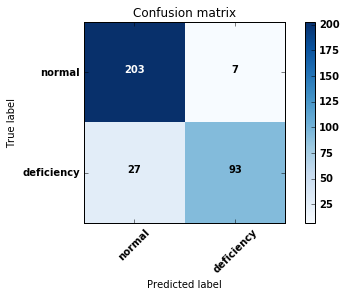

In [53]:


linearSVC = LinearSVC(C=0.8, penalty="l2", dual=False, loss='squared_hinge')
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
gnb = GaussianNB()


x_train = transform_x(x_train_all, feature_set_t_test)
y_true = y_labels_2c[:]

rfc.fit(x_train, y_true)
y_pred = rfc.predict(x_train)

c_matrix = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(c_matrix, classes=["normal", "deficiency"], title='Confusion matrix')
plt.show()

In [ ]:
rfc = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, min_samples_leaf=4)
rfecv_svc = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10),
                  scoring='accuracy')
x_train_svc = rfecv_svc.fit_transform(x_train_all, y_labels)
print("--- Most predictive features SVM ---")